In [195]:
import numpy as np 
import pandas as pd 
import h5py
import re
import uproot
import glob 
import matplotlib.pyplot as plt
from tqdm import tqdm 
from utils import ParticleCode

# Load your custom style 
plt.style.use('./cfg/my_custom_plot.mplstyle')

# use these lines on top of your matplotlib script
import matplotlib.ticker
class MyLocator(matplotlib.ticker.AutoMinorLocator):
    def __init__(self, n=4):
        super().__init__(n=n)
matplotlib.ticker.AutoMinorLocator = MyLocator        
 
# Now use matplotlib as usual.       
import matplotlib.pyplot as plt
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True

In [196]:
# Geometry for MiniRun 5
anode_xs = np.array([-63.931, -3.069, 3.069, 63.931])
anode_ys = np.array([-19.8543, 103.8543])  # two ys
anode_zs = np.array([-64.3163, -2.6837, 2.6837, 64.3163])  # four zs

# hit coordinates are in cm
detector_center = (0, 0, 0)
anode_ys = anode_ys - 42

In [197]:
f_directory = "/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta2a/FLOW"
plot_dir = "./plots/"

# TO DO: Use hadron subprocess label! 
# G4 Subprocess labels
HadronElastic = 111
HadronInelastic = 121
HadronCapture = 131
HadronChargeExchange = 161
NeutronKiller=403
EMScintillation = 22 
GeneralStepLimit=401
Hadronic = 4
Decay = 6 


# Number of files
n_files = 885

In [198]:
def check_atom_pdg(number):
    # Define the regex pattern
    pattern = r'^100\d{3}\d{3}0$'
    
    # Convert the number to a string
    number_str = str(number)
    
    # Check if the number matches the pattern
    match = re.match(pattern, number_str)
    
    # Return True if it matches, False otherwise
    return bool(match)

In [199]:
print(check_atom_pdg(ParticleCode().argon))
print(check_atom_pdg(1000170380))

True
True


In [200]:
n_signal_energy  = [] 
proton_signal_energy = []

np_dict  = {
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'proton_energy':[],
    'proton_start':[],
    'proton_end':[]
}


ngamma_dict = {
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'gamma_energy':[]
}

In [201]:
# Signal channel:  n + Ar -> Cl + Nn + 1p 
# Signal channel: n + Ar -> Ar* + gamma + n 


''' 

DEVELOPER NOTES:

* Why are e- and e+ being
linked to neutrons???

* A neutron can 
interact more than once
we can check this by looking
how many different vertex
are in its daughter list

* There could be more
argon isotopes/atoms
that might be of interest...
Use helper function for this 


* Add a function
to count the number of n-p per interaction 

* Count the number of nu interactions
producing signal, if at least one n-p then -> Signal 


'''

def signal_finder(traj,chan,sig_dict):
    primary_n_traj = traj[(traj['pdg_id'] == ParticleCode().neutron)&
                          (traj['primary'] == True) &
                          (traj['end_process'] == Hadronic) &
                          (traj['end_subprocess'] == HadronInelastic)]
    

    n_np_ixn = 0 
    #print('Number of neutrons ',len(primary_n_traj))
    for n in primary_n_traj:
        n_id = n['traj_id']
        d_mask = np.isin(traj['parent_id'],n_id)
        d_trajs = traj[d_mask]

        # Let's start by addding a constraint: only hadron inelastic start
        d_trajs = d_trajs[(d_trajs['start_process'] == Hadronic) & (d_trajs['start_subprocess'] == HadronInelastic)]


        # debug 

        '''
        print('neutron id', n_id)
        print('PDG check', n['pdg_id'])
        print('This n has these daughters: ', d_trajs['pdg_id'])
        print('With the following ids: ', d_trajs['traj_id'])
        print('With the following parent ids: ', d_trajs['parent_id'])
        print('With the following starting points', d_trajs['xyz_start'])
        print('With the following starting times', d_trajs['t_start'])
        print('With the following start process', d_trajs['start_process'])
        print('With the following start subprocess', d_trajs['start_subprocess'])
        print('\n')
        '''
 

        n_neutrons = np.sum(d_trajs['pdg_id'] == ParticleCode().neutron)
        n_protons = np.sum(d_trajs['pdg_id'] == ParticleCode().proton)
        n_chlorine = np.sum(d_trajs['pdg_id'] == ParticleCode().chlorine)
        n_gamma = np.sum(d_trajs['pdg_id'] == ParticleCode().photon)
        n_argon = np.sum(d_trajs['pdg_id'] == ParticleCode().argon)

        np_len = 2 + n_neutrons 
        ngamma_len = 1 + n_gamma + n_neutrons 

        # Check for np channel and fill dictionary 
        if((chan == 'np') & 
           ((len(d_trajs) == np_len) & # Number of daughters equals to Cl + p + Nn 
            (n_chlorine == 1)&
            (n_protons == 1))):
            p_index = np.where(d_trajs['pdg_id'] == ParticleCode().proton)
            sig_dict['neutron_energy'].append(n['E_start'] - ParticleCode().neutron_mass)
            sig_dict['proton_energy'].extend(d_trajs['E_start'][p_index] - ParticleCode().proton_mass)  
            n_np_ixn +=1 

        # Check for ngamma channel and fill dictionary 
        # Daughter array should have only: One argon, One neutron and One photon, could there be more (?) 
        elif((chan=='ngamma') & (
           (len(d_trajs) == ngamma_len) &  # Number of daughters equals to Ar + Ngamma + Nn 
           (n_argon == 1))):
            gamma_index = np.where(d_trajs['pdg_id'] == ParticleCode().photon)
            sig_dict['neutron_energy'].append(n['E_start'] - ParticleCode().neutron_mass)
            sig_dict['gamma_energy'].extend(d_trajs['E_start'][gamma_index])
        else:
            continue 

        return n_np_ixn 







In [202]:
file_counter=0
for filename in tqdm(glob.glob(f_directory+'/*/*.hdf5')):
    f=h5py.File(filename,'r')
    file_counter+=1

    # Nu interactions
    Interactions = f['mc_truth/interactions/data']

    # True Particle information 
    MCStack = f['mc_truth/stack/data']

    # True Particle Trajectories 
    Trajectories = f['mc_truth/trajectories/data']

    # Apply filter for interactions with Ar only and inside the detector (not FV!)
    Ar_id_temp = Interactions[(Interactions['target']==18) & 
                              (Interactions['x_vert'] >= anode_xs[0]) & (Interactions['x_vert'] <= anode_xs[3]) &
                              (Interactions['y_vert'] >= anode_ys[0]) & (Interactions['y_vert'] <= anode_ys[1]) &
                              (Interactions['z_vert'] >= anode_zs[0]) & (Interactions['z_vert'] <= anode_zs[3]) 
                              ]['vertex_id']
    
    # Masking out interactions
    int_mask = np.isin(Interactions['vertex_id'], Ar_id_temp)
    Interactions = Interactions[int_mask]
    mask_stack = np.isin(MCStack['vertex_id'], Ar_id_temp)
    mask_traj = np.isin(Trajectories['vertex_id'], Ar_id_temp)
    MCStack_ar = MCStack[mask_stack]
    Trajectories_ar = Trajectories[mask_traj]

    for ixn in Ar_id_temp:
        #print('vertex id', ixn)
        ixn_traj = Trajectories_ar[Trajectories_ar['vertex_id'] == ixn]
        signal_finder(ixn_traj,'np',np_dict)
        signal_finder(ixn_traj,'ngamma',ngamma_dict)





    if file_counter==n_files: break

  0%|          | 1/884 [00:00<04:01,  3.66it/s]

100%|██████████| 884/884 [01:23<00:00, 10.54it/s]


In [203]:
print(len(ngamma_dict['neutron_energy']))
print(len(ngamma_dict['gamma_energy'])) 

print(np.max(ngamma_dict['neutron_energy']))


7467
12429
1789.967070703125


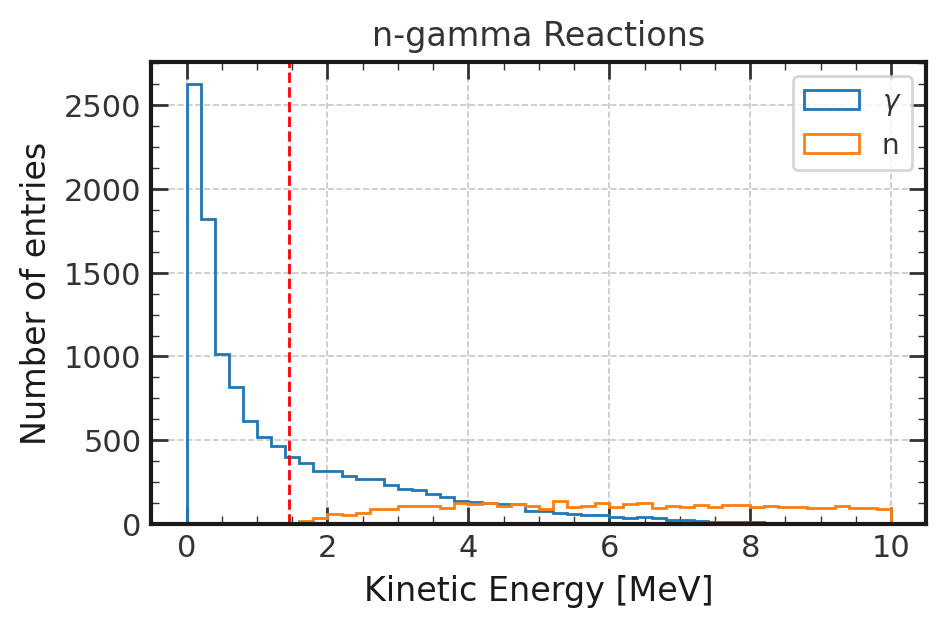

In [204]:
plt.hist(ngamma_dict['gamma_energy'],bins=50,range=(0,10.),histtype='step',label=r'$\gamma$')
plt.hist(ngamma_dict['neutron_energy'],bins=50,range=(0,10.),histtype='step',label='n')
plt.title("n-gamma Reactions")
plt.ylabel('Number of entries')
plt.xlabel('Kinetic Energy [MeV]')
plt.axvline(1.46,0,1,ls="--",lw=1.,color='red')
plt.legend()
plt.show()

In [205]:
print(len(np_dict['neutron_energy']))
print(len(np_dict['proton_energy']))

70
70


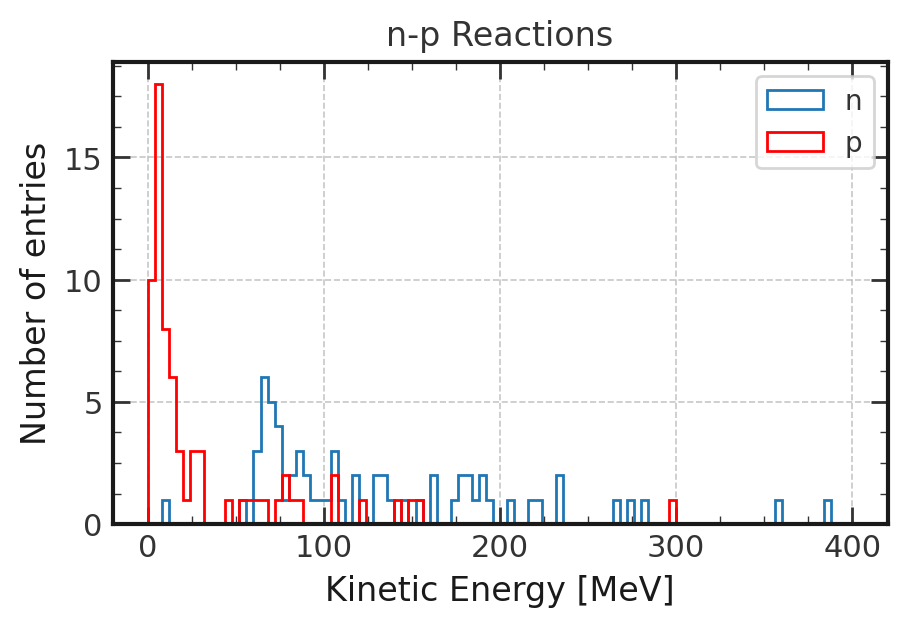

In [206]:
plt.hist(np_dict['neutron_energy'],bins=100,range=(0,400.),histtype='step',label='n')
plt.hist(np_dict['proton_energy'],bins=100,range=(0,400.),histtype='step', color='red',label ='p')
plt.title("n-p Reactions")
plt.ylabel('Number of entries')
plt.xlabel('Kinetic Energy [MeV]')
plt.legend()
plt.show()

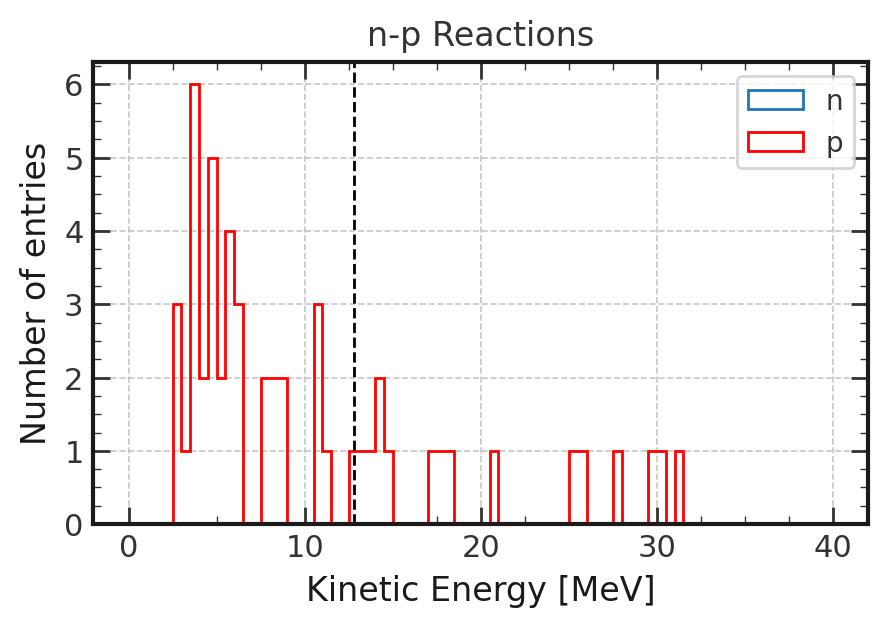

In [207]:
plt.hist(np_dict['neutron_energy'],bins=20,range=(12.,40.),histtype='step',label='n')
plt.hist(np_dict['proton_energy'],bins=80,range=(0,40.),histtype='step', color='red',label ='p')
plt.title("n-p Reactions")
plt.ylabel('Number of entries')
plt.xlabel('Kinetic Energy [MeV]')
plt.axvline(12.8,0,1,ls="--",lw=1.,color='black')
plt.legend()
plt.show()

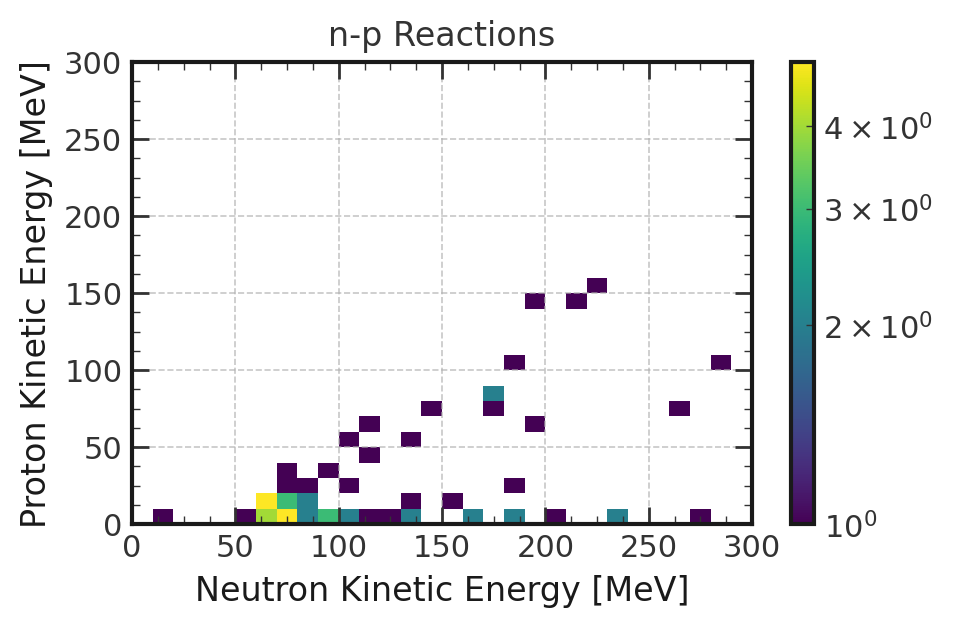

In [208]:
import matplotlib as mpl
plt.hist2d(np_dict['neutron_energy'],np_dict['proton_energy'],
           bins=30,range=[[0,300],[0,300]],
           norm=mpl.colors.LogNorm())
plt.colorbar()
plt.title("n-p Reactions")
plt.ylabel('Proton Kinetic Energy [MeV]')
plt.xlabel('Neutron Kinetic Energy [MeV]')
plt.show()